<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/gradient_boosting_newest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd

In [30]:
!git clone https://github.com/dernameistegal/airbnb_price.git

fatal: destination path 'airbnb_price' already exists and is not an empty directory.



# Gradient Boosting regression

This example demonstrates Gradient Boosting to produce a predictive
model from an ensemble of weak predictive models. Gradient boosting can be used
for regression and classification problems. Here, we will train a model to
tackle a diabetes regression task. We will obtain the results from
:class:`~sklearn.ensemble.GradientBoostingRegressor` with least squares loss
and 500 regression trees of depth 4.

Note: For larger datasets (n_samples >= 10000), please refer to
:class:`~sklearn.ensemble.HistGradientBoostingRegressor`.


In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
%cd airbnb_price
import sys
sys.path.append("/content/airbnb_price/custom_functions")
import general_utils as ut

/content/airbnb_price/airbnb_price


In [50]:
listings =pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/data1/listings_withcategorical_better.pickle")

In [51]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Maria Telenczuk <https://github.com/maikia>
#         Katrina Ni <https://github.com/nilichen>
#
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime
import pandas as pd
from xgboost import XGBRegressor

## Load the data




In [52]:
columns1 = set(listings.columns)
listings = listings.select_dtypes([np.number])
columns2 = set(listings.columns)
columns1 - columns2

{'description_en', 'host_about_en', 'name_en', 'reviews_en'}

In [53]:
train_ids, val_ids, test_ids = ut.train_val_test_split(listings.index)  
traindf = listings.loc[train_ids]
valdf = listings.loc[val_ids]

In [54]:
y = listings["log_price"]
X = listings[listings.columns.difference(["price", "log_price"])] 


y_train, y_test = traindf["log_price"], valdf["log_price"]
X_train, X_test = traindf[traindf.columns.difference(["price", "log_price"])], valdf[valdf.columns.difference(["price", "log_price"])]


# Normal Gradient Boosting

In [93]:
params = {
    "n_estimators": 5000,
    "max_depth": 10,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
    "max_features": 0.05
}

In [94]:
# Baseline performance
mean_prediction = np.mean(y_train)

mse = mean_squared_error(y_test, np.ones(len(y_test)) * mean_prediction)
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

The root mean squared error (MSE) on test set: 0.6490


## Fit regression model

Now we will initiate the gradient boosting regressors and fit it with our
training data. Let's also look and the mean squared error on the test data.



In [95]:
start = datetime.now()

reg = ensemble.GradientBoostingRegressor(**params, verbose=1)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))

end = datetime.now()
print("time to obtain model: ", (end-start).total_seconds())
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

      Iter       Train Loss   Remaining Time 
         1           0.4326            1.76m
         2           0.4279            1.85m
         3           0.4234            2.16m
         4           0.4191            6.60m
         5           0.4146            5.87m
         6           0.4105            5.26m
         7           0.4061            4.98m
         8           0.4019            4.55m
         9           0.3976            4.36m
        10           0.3937            4.06m
        20           0.3566            2.69m
        30           0.3239            2.49m
        40           0.2961            2.20m
        50           0.2713            2.02m
        60           0.2497            1.87m
        70           0.2306            1.77m
        80           0.2137            1.70m
        90           0.1992            1.63m
       100           0.1854            1.59m
       200           0.1065            1.37m
       300           0.0743            1.32m
       40

## Plot training deviance

Finally, we will visualize the results. To do that we will first compute the
test set deviance and then plot it against boosting iterations.



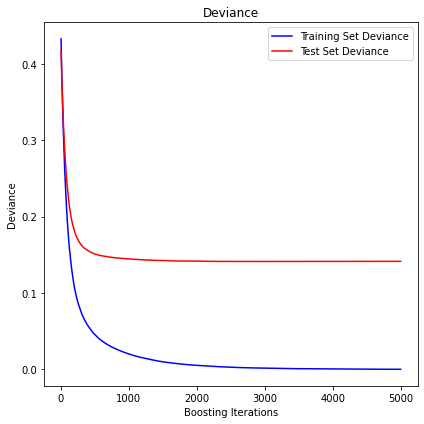

In [96]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

## Plot feature importance

<div class="alert alert-danger"><h4>Warning</h4><p>Careful, impurity-based feature importances can be misleading for
   **high cardinality** features (many unique values). As an alternative,
   the permutation importances of ``reg`` can be computed on a
   held out test set. See `permutation_importance` for more details.</p></div>

For this example, the impurity-based and permutation methods identify the
same 2 strongly predictive features but not in the same order. The third most
predictive feature, "bp", is also the same for the 2 methods. The remaining
features are less predictive and the error bars of the permutation plot
show that they overlap with 0.



/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


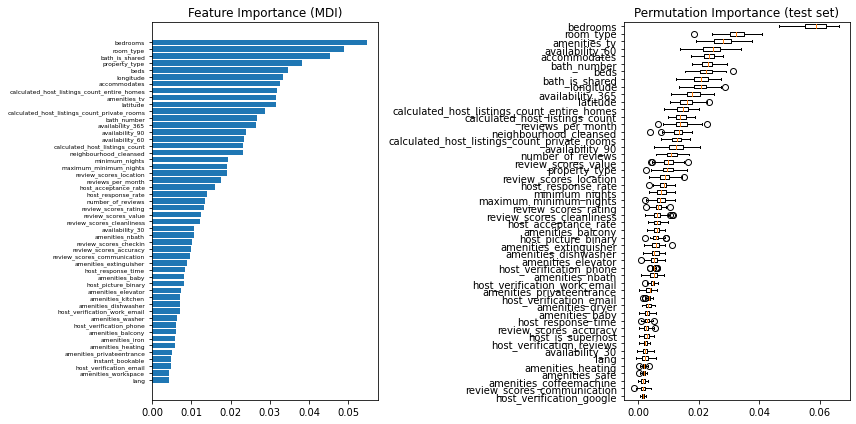

time to generate permutation importance:  7420.297928


In [97]:
start = datetime.now()
n_features = 50

feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_idx = sorted_idx[:n_features][::-1]
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx], fontsize=6)
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=100, random_state=42, n_jobs=2
)
sorted_idx2 = result.importances_mean.argsort()[::-1]
sorted_idx2 = sorted_idx2[:n_features][::-1]
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx2].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx2],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

end = datetime.now()
print("time to generate permutation importance: ", (end-start).total_seconds())

In [99]:
# make dataframe from feature importances
df = pd.DataFrame(result.importances, index=X.columns)

In [101]:
# save dataframe 
path = "/content/drive/MyDrive/Colab/airbnb/data/feature_selection/permutation_importance_morefeatures_emergencysave.pickle"
df.to_pickle(path)

In [102]:
# load dataframe
df = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/feature_selection/permutation_importance_morefeatures_emergencysave.pickle")

In [103]:
# calculate importances_mean
importances_mean = np.array(np.mean(df, axis=1))

In [104]:
# significance test
significant = np.sum(np.array(df) >= 0, axis=1) >= 95
index_significant = np.where(significant)[0]

In [107]:
# get column names, importances and mean importances that are significant
importances_mean_significant = importances_mean[index_significant]
importances_significant = np.array(df)[index_significant]
columns_significant = df.index[index_significant]

In [108]:
# argsort to select only the 69 most important features of all significant features
sorted_idx = importances_mean_significant.argsort()[::-1]
sorted_idx = sorted_idx[:82]
sorted_idx = sorted_idx[::-1]

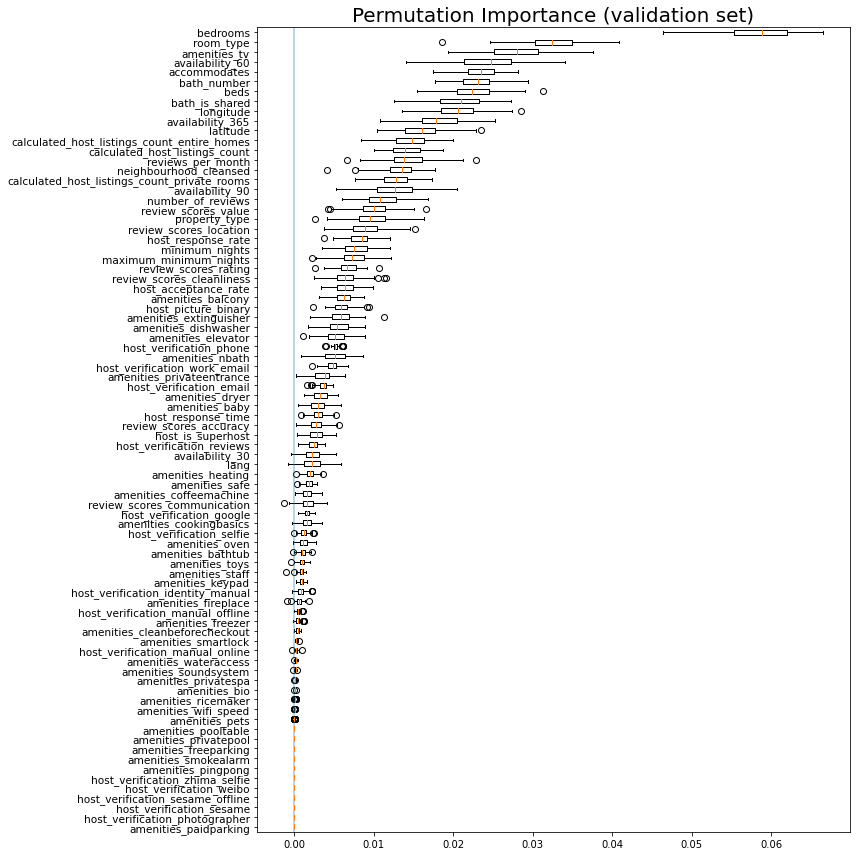

In [117]:
fig = plt.figure(figsize=(12, 12))
plt.yticks(fontsize=10.5)
plt.boxplot(
    importances_significant[sorted_idx].T,
    vert=False,
    labels=np.array(columns_significant)[sorted_idx],
)
plt.axvline(x=0, alpha=0.4)
plt.title("Permutation Importance (validation set)", fontsize=20)
fig.tight_layout()
plt.savefig(str("/content/file0.svg"), bbox_inches='tight', format="svg", transparent=True)
plt.show()

In [118]:
np.save("/content/drive/MyDrive/Colab/airbnb/data/feature_selection/selected_features_morefeatures.npy", np.array(columns_significant)[sorted_idx])